In [1]:
import sys 
sys.path.append('../')

import pandas as pd 
import numpy as np 
from core.semiGP import GP
from core.glm import GLM
from core.gp2 import GP as GP_zero

import matplotlib.pylab as plt 
import matplotlib
from getdist import plots, MCSamples
import getdist

plt.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20
%matplotlib inline

# KiDS-450

In [2]:
!ls -l ../examples/kids/

total 1452
-rw-r--r-- 1 harry harry  368921 Apr  9 19:19 1000_8D_table_prior_moped_3_998.csv
-rw-r--r-- 1 harry harry 1111601 May  5 17:05 3000_8D_table_prior_moped_3_3000.csv


In [3]:
data = pd.read_csv('../Data/optimum/1000_table.csv', index_col =0)

In [4]:
# data = pd.read_csv('../examples/kids/1000_8D_table_prior_moped_3_998.csv').iloc[:,1:]
indexMoped = 1
X = np.array(data.iloc[:,0:8])
yo = np.array(data.iloc[:,7+indexMoped])

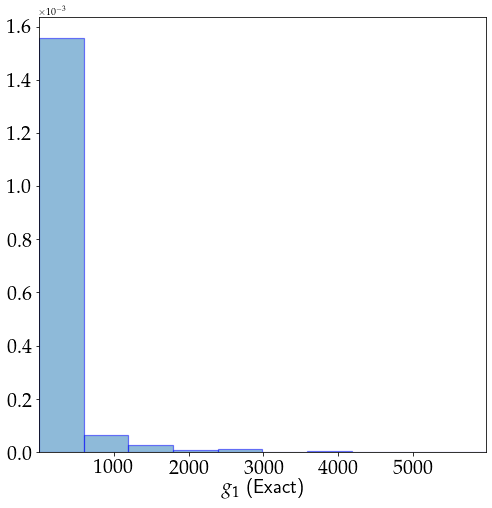

In [5]:
plt.figure(figsize = (8,8))
plt.hist(yo, density = True, edgecolor='blue', linewidth=1.2, alpha = 0.5, bins = 10)
plt.xlabel('$g_{%d}$ (Exact)'%indexMoped, fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlim(min(yo), max(yo))
# plt.savefig('/Users/Harry/Desktop/originalMOPED_'+str(indexMoped)+'.pdf', bbox_inches='tight')
plt.show()

In [6]:
myGLM = GLM(X, yo, Var=1E-6, Xtrans = True, Ytrans = False, useMean = False)
myGLM.makeTransformation()
D = myGLM.computeBasis(order = 2)

In [7]:
myGLM.regressionPrior(Lambda = 1000)
logZ = myGLM.Evidence()
post_beta, cov_beta = myGLM.posteriorCoefficients()

      The log-Evidence is -53602244243001.02      


In [8]:
res = myGLM.yTrain - (np.dot(myGLM.PHI, post_beta)+myGLM.meanFunction)#np.atleast_2d(y).T - np.dot(myGLM.PHI, post_beta)
res = res.flatten()

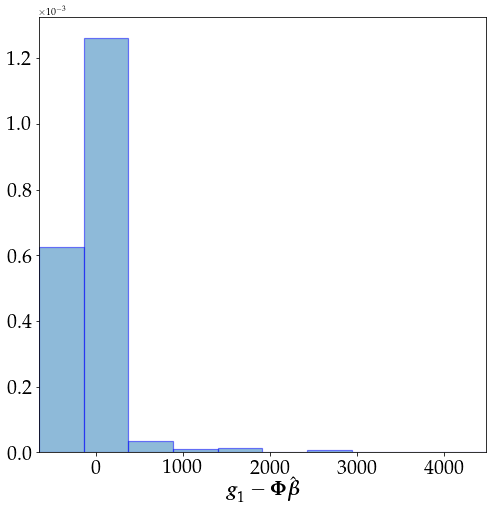

In [9]:
plt.figure(figsize = (8,8))
plt.hist(res, density = True, edgecolor='blue', linewidth=1.2, alpha = 0.5, bins = 10)
plt.xlabel(r'$\boldsymbol{g}_{%d}-\boldsymbol{\Phi}\hat{\boldsymbol{\beta}}$'%indexMoped, fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlim(min(res), max(res))
# plt.savefig('/Users/Harry/Desktop/residual_'+str(indexMoped)+'.pdf', bbox_inches='tight')
plt.show()

In [10]:
Nparams = 9
myGP = GP(X, yo, optParams=np.zeros(Nparams), Var = 1E-6, Xtrans = True, yTrans = False, jitter=1E-10, useMean = False)

# Make appropriate transformation
myGP.makeTransformation()

# Compute design matrix 
PHI = myGP.computeBasis(order = 2)

# Input regression prior (default: 0 mean and unit variance: inputs -> mean = None, cov = None, Lambda = 1)
# myGP.regressionPrior(mean = post_beta, cov = np.identity(post_beta.shape[0]), Lambda = 1)
myGP.regressionPrior(mean = np.zeros(PHI.shape[1]), cov = np.identity(PHI.shape[1]), Lambda = 1000)

# Set bound (prior for kernel hyperparameters)
bnd    = np.repeat(np.array([[-5.0, 5.0]]), Nparams, axis = 0)

# Amplitude is important 
amp    = 2*np.log(np.std(res))
bnd[0] = np.array([amp-2, amp+10])

In [11]:
bnd[0]

array([9.5825, 21.5825])

In [12]:
# run optimisation 
myGP.fit(method = 'L-BFGS-B', bounds = bnd, options = {'ftol':1E-20, 'maxiter':500}, Nrestart = 5)

Performing Optimization step 1
Performing Optimization step 2
Performing Optimization step 3
Performing Optimization step 4
Performing Optimization step 5
[4720.4437 4720.4437 4720.4437 4720.4437 4720.4437]
[14.4055 0.6435 0.4388 3.3394 3.8109 1.2259 0.1835 1.6828 5.0000]


In [13]:
testPoint = np.array([0.35, 0.022, 2.47, 1.13, 0.75, 1.0, 0.5, -1.72])

In [14]:
%%time
a, b = myGP.prediction(testPoint, returnVar=True)

CPU times: user 13.3 ms, sys: 0 ns, total: 13.3 ms
Wall time: 3.09 ms


In [15]:
a

array([[125.0491]])

In [16]:
b

array([[8.9924]])

In [17]:
myGP.derivatives(testPoint, order = 2)

(array([1120.9278, -1942.4006, 155.7449, 328.7458, -421.8775, -4.3182,
        -13.3917, -26.7240]),
 array([7782.7195, -100146.8696, 170.8918, 1784.0878, 1452.3353, -2.6750,
        11.1739, 3.3381]))

In [18]:
ndim  = 5
samps = np.random.multivariate_normal(myGP.betaHat.flatten()[0:ndim], myGP.Vbeta[0:ndim, 0:ndim], 50000)
#samps2 = np.random.multivariate_normal(post_beta.flatten()[0:ndim], cov_beta[0:ndim, 0:ndim], 50000)
names = ["x%s"%i for i in range(ndim)]
labels =  [r"\beta_{%s}"%i for i in range(ndim)]
samples1 = MCSamples(samples=samps,names = names, labels = labels)
#samples2 = MCSamples(samples=samps2,names = names, labels = labels)

Removed no burn in


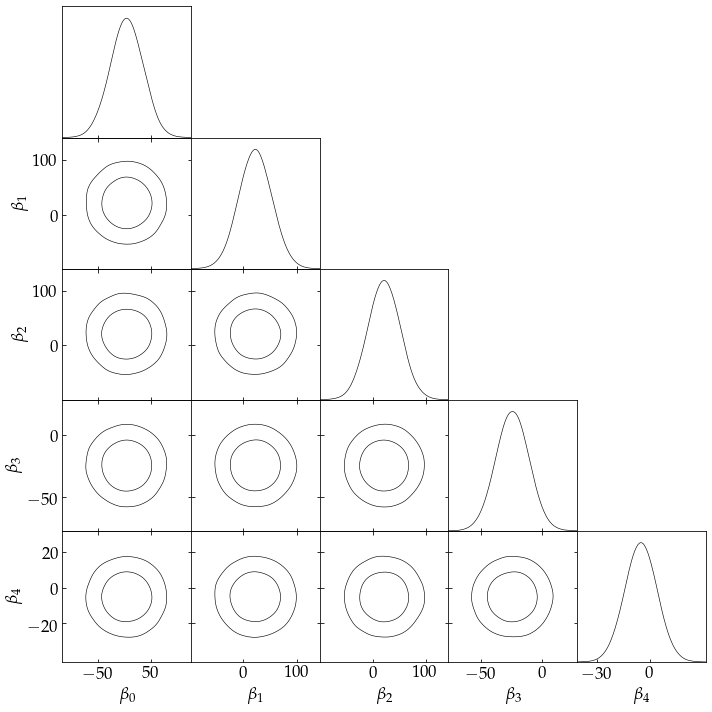

In [19]:
plt.rcParams['text.latex.preamble'] = r'\newcommand{\mathdefault}[1][]{}'
g = plots.get_subplot_plotter()
g.settings.num_plot_contours = 2
samples1.updateSettings({'contours': [0.68, 0.95]})
g.settings.lw_contour = 4
g.settings.axes_fontsize = 20
g.settings.lab_fontsize = 20
g.settings.legend_fontsize = 10
# g.settings.alpha_filled_add = 0.6
# g.settings.scaling_factor = 1.5
g.triangle_plot([samples1])#, samples2])
plt.show()

In [20]:
post_beta.flatten()[0:ndim]

array([-98.7318, 135.5735, 151.5685, -12.2992, 1.7950])

In [21]:
np.sqrt(np.diag(cov_beta[0:ndim, 0:ndim]))

array([0.0001, 0.0000, 0.0000, 0.0000, 0.0000])

In [22]:
m, c = myGP.posterior()
meanGP = m[PHI.shape[1]:].flatten()
covGP  = c[PHI.shape[1]:, PHI.shape[1]:]

In [29]:
m.flatten()[0:ndim]

array([4.4844, 22.6250, 21.4062, -24.5626, -5.0539, -19.3984, 24.6875,
       -33.1094, -2.2770, 49.8984, 25.0781, -0.7897, 0.0543, 9.9619,
       29.8906])

In [23]:
np.diag(c[0:myGP.nbasis, 0:myGP.nbasis])

array([994.5573, 934.9515, 949.0527, 183.3712, 85.6388, 869.8859,
       961.7361, 767.4104, 12.2361, 627.2392, 741.2797, 0.4838, 0.1219,
       262.9840, 828.7084, 88.5147, 0.0241])

In [26]:
ndim  = 15
samps = np.random.multivariate_normal(meanGP[0:ndim], covGP[0:ndim, 0:ndim], 50000)
names = ["x%s"%i for i in range(ndim)]
labels =  [r"f_{%s}"%i for i in range(ndim)]
samples = MCSamples(samples=samps,names = names, labels = labels)

Removed no burn in


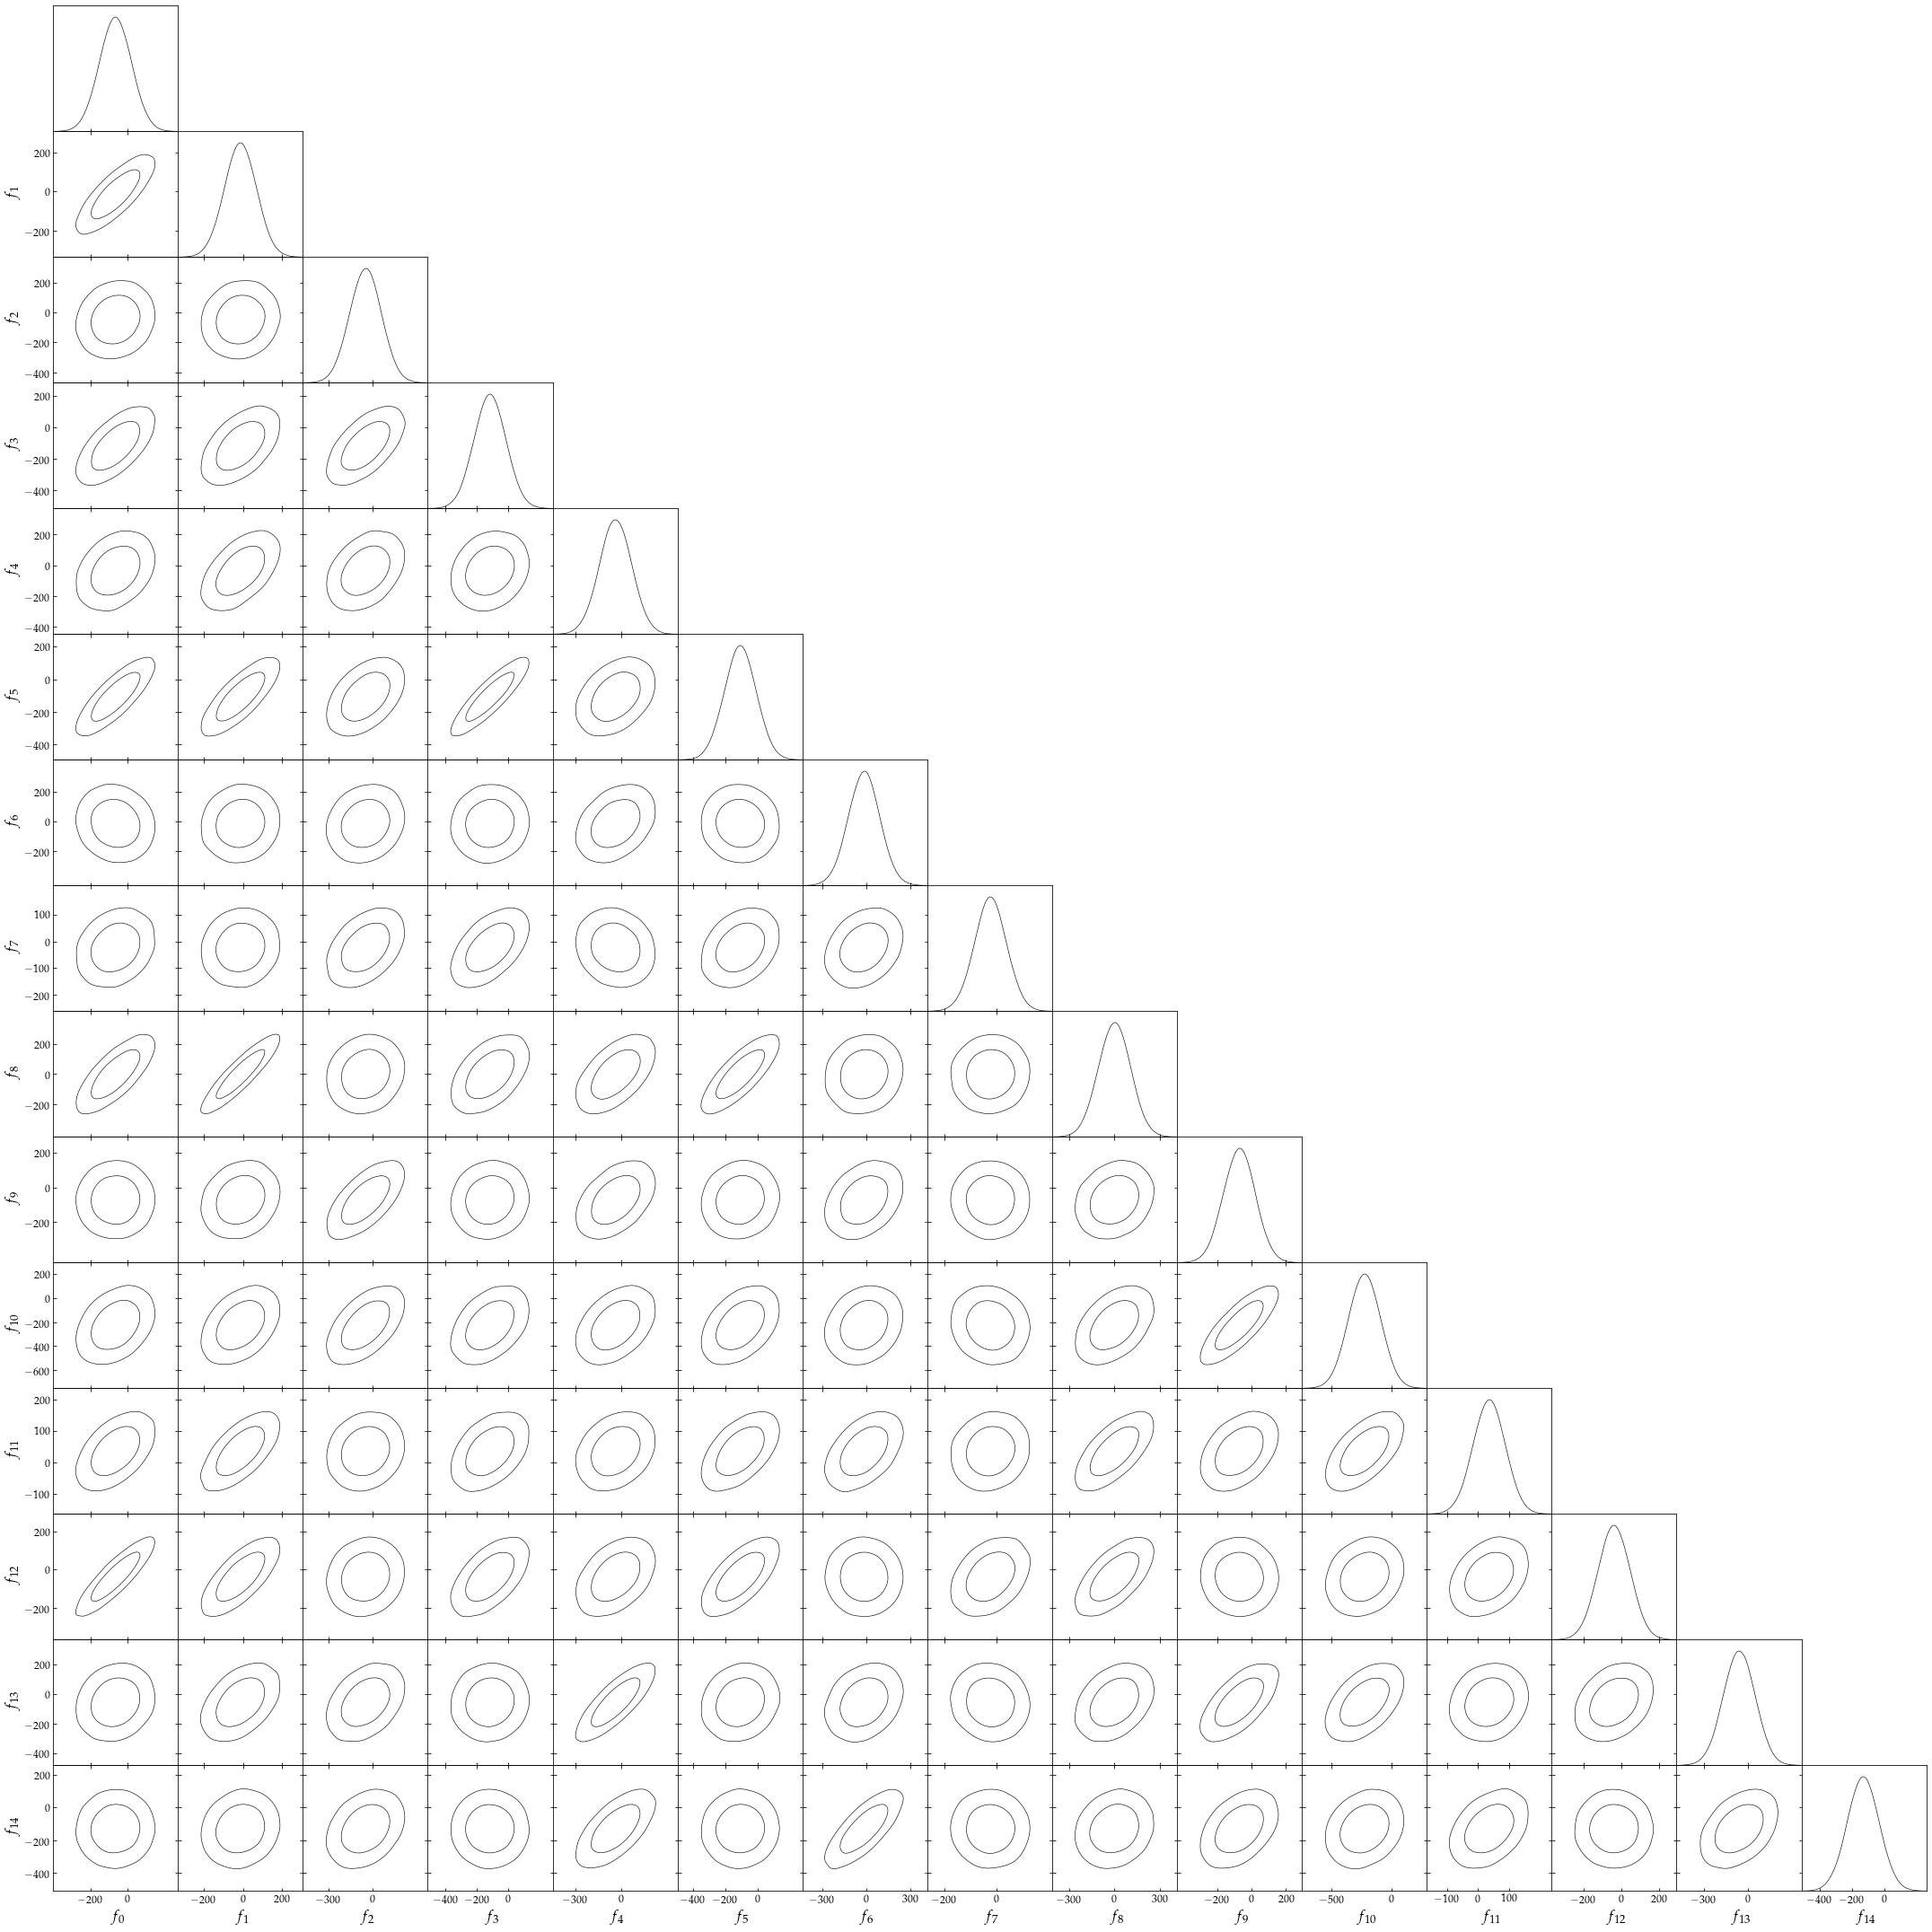

In [27]:
#plt.rcParams['text.latex.preamble'] = r'\newcommand{\mathdefault}[1][]{}'
g = plots.get_subplot_plotter()
g.settings.num_plot_contours = 2
samples.updateSettings({'contours': [0.68, 0.95]})
g.settings.lw_contour = 4
g.settings.axes_fontsize = 15
g.settings.lab_fontsize = 20
g.settings.legend_fontsize = 10
# g.settings.alpha_filled_add = 0.6
# g.settings.scaling_factor = 1.5
g.triangle_plot([samples])
plt.show()

### Zero Mean GP

In [ ]:
mytest = np.c_[X, yo.reshape(len(yo),1)]
sigma  = 0.5*np.log(1E-6)
ndim   = 8
mygp   = GP_zero(mytest, sigma=sigma, train = True, nrestart = 2, ndim = ndim)
mygp.transform()
#bnd    = np.repeat(np.array([[-1.0, 5.0]]), ndim, axis = 0)
bnd    = np.repeat(np.array([[-5,5]]), ndim+1, axis = 0)
bnd[0] = np.array([amp-2, amp+10])


In [ ]:
mygp.fit(method = 'L-BFGS-B', bounds = bnd, options = {'ftol':1E-12, 'maxiter':500})

In [ ]:
plt.figure(figsize = (8,8))
plt.hist(mygp.y, density = True, edgecolor='blue', linewidth=1.2, alpha = 0.5, bins = 10)
plt.xlabel('$g_{%d}$ (Exact)'%indexMoped, fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlim(min(mygp.y), max(mygp.y))
plt.show()

In [ ]:
mygp.prediction(testPoint)

In [ ]:
mygp.returnSample(testPoint, mean = True)

# JLA 

In [ ]:
data = pd.read_csv('../examples/jla/data/table_lhs_700.csv').iloc[:,1:]
X = np.array(data.iloc[:,0:6])
y = np.array(data.iloc[:,6])

### Gaussian Linear Model 

In [ ]:
myGLM = GLM(X, y, Var=1E-6, Xtrans = True, Ytrans = False, useMean=False)
myGLM.makeTransformation()
D = myGLM.computeBasis(order = 2)
myGLM.regressionPrior(Lambda = 1)
logZ = myGLM.Evidence()
post_beta, cov_beta = myGLM.posteriorCoefficients()

In [ ]:
res = np.atleast_2d(y).T - np.dot(myGLM.PHI, post_beta)
res = res.flatten()

In [ ]:
plt.hist(res, density=True)
plt.show()

### Gaussian Process

In [ ]:
Nparams = 7
myGP = GP(X, y, optParams=np.zeros(Nparams), Var = 1E-6, Xtrans = True, yTrans = False, jitter=1E-10, useMean = False)

In [ ]:
# Make appropriate transformation
myGP.makeTransformation()

# Compute design matrix 
PHI = myGP.computeBasis(order = 2)

# Input regression prior (default: 0 mean and unit variance: inputs -> mean = None, cov = None, Lambda = 1)
myGP.regressionPrior(mean = post_beta, cov = cov_beta, Lambda = 10)

# Set bound (prior for kernel hyperparameters)
bnd    = np.repeat(np.array([[-5.0, 5.0]]), Nparams, axis = 0)

# Amplitude is important 
amp    = 2*np.log(np.std(res))
bnd[0] = np.array([amp-2, amp+10])

In [ ]:
myGP.fit(method = 'L-BFGS-B', bounds = bnd, options = {'ftol':1E-20, 'maxiter':500}, Nrestart = 5)

### Getdist Plot

In [ ]:
ndim  = 5
samps = np.random.multivariate_normal(myGP.betaHat.flatten()[0:ndim], myGP.Vbeta[0:ndim, 0:ndim], 50000)
names = ["x%s"%i for i in range(ndim)]
labels =  [r"\beta_{%s}"%i for i in range(ndim)]
samples = MCSamples(samples=samps,names = names, labels = labels)

# samps = np.random.multivariate_normal(myGP.betaHat.flatten(), myGP.Vbeta, 50000)
# ndim  = myGP.Vbeta.shape[0]
# names = ["x%s"%i for i in range(ndim)]
# labels =  [r"x_{%s}"%i for i in range(ndim)]
# samples = MCSamples(samples=samps,names = names, labels = labels)

In [ ]:
plt.rcParams['text.latex.preamble'] = r'\newcommand{\mathdefault}[1][]{}'
g = plots.get_subplot_plotter()
g.settings.num_plot_contours = 2
samples.updateSettings({'contours': [0.68, 0.95]})
g.settings.lw_contour = 4
g.settings.axes_fontsize = 20
g.settings.lab_fontsize = 20
g.settings.legend_fontsize = 10
# g.settings.alpha_filled_add = 0.6
# g.settings.scaling_factor = 1.5
g.triangle_plot([samples])
plt.show()

### GetDist Plot for the First Few Residuals

In [ ]:
m, c = myGP.posterior()

In [ ]:
meanGP = m[13:].flatten()
covGP  = c[13:, 13:]

In [ ]:
ndim  = 5
samps = np.random.multivariate_normal(meanGP[0:ndim], covGP[0:ndim, 0:ndim], 50000)
names = ["x%s"%i for i in range(ndim)]
labels =  [r"f_{%s}"%i for i in range(ndim)]
samples = MCSamples(samples=samps,names = names, labels = labels)

In [ ]:
plt.rcParams['text.latex.preamble'] = r'\newcommand{\mathdefault}[1][]{}'
g = plots.get_subplot_plotter()
g.settings.num_plot_contours = 2
samples.updateSettings({'contours': [0.68, 0.95]})
g.settings.lw_contour = 4
g.settings.axes_fontsize = 20
g.settings.lab_fontsize = 20
g.settings.legend_fontsize = 10
# g.settings.alpha_filled_add = 0.6
# g.settings.scaling_factor = 1.5
g.triangle_plot([samples])
plt.show()

In [ ]:
# Npoint = 200
# xRange = np.linspace(-4, 2, Npoint)
# params = np.c_[-7.44*np.ones((Npoint, 1)), xRange.reshape(Npoint, 1)]
# rec    = np.array([myGP.Evidence(params[i])[0] for i in range(Npoint)]).flatten()

# plt.figure(figsize = (12, 8))
# plt.plot(xRange, rec, lw = 2)
# plt.ylabel(r'$\textrm{log }\mathbb{Z}$', fontsize = fontSize)
# plt.xlim(min(xRange), max(xRange))
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.xlabel(r'$\nu_{0}$', fontsize = fontSize)
# plt.tick_params(axis='x', labelsize=fontSize)
# plt.tick_params(axis='y', labelsize=fontSize)
# # plt.savefig('/Users/Harry/Desktop/cost_.pdf', bbox_inches='tight')
# plt.show()

In [ ]:
testPoint = np.array([0.15, -1.0, -19.0, 0.0, 0.125, 2.6])

In [ ]:
eps       = 1E-4
testPoint1 = np.array([0.15+eps, -1.0, -19.0, 0.0, 0.125, 2.6])
testPoint2 = np.array([0.15-eps, -1.0, -19.0, 0.0, 0.125, 2.6])

In [ ]:
(myGP.prediction(testPoint=testPoint1) - myGP.prediction(testPoint=testPoint2))/(2*eps) 

In [ ]:
# [-1168.4624  -546.0511   702.0807     2.79      14.3995    33.0007]
myGP.prediction(testPoint, returnVar=True)

In [ ]:
# (myGP.predOriginalFunction(testPoint=testPoint1) - myGP.predOriginalFunction(testPoint=testPoint2))/(2*eps) 

In [ ]:
# myGP.predOriginalFunction(testPoint=testPoint)

In [ ]:
# -106.2411,    8.6312,   -4.9495,  -15.0657, -307.0462,   -1.0553

In [ ]:
g1, g2 = myGP.derivatives(testPoint, order = 2)

In [ ]:
g1

In [ ]:
g2

In [ ]:
1./g2

In [ ]:
# x_ = (myGP.theta - np.mean(myGP.theta, axis = 0))/np.std(myGP.theta, axis = 0)

# cov              = np.cov(x_.T)
# a, b, c          = np.linalg.svd(cov)
# M                = np.diag(1.0/np.sqrt(b))
# MU          = np.dot(M, c)      
# theta_trans = np.dot(MU, x_.T)
# theta_trans = theta_trans.T

# from functools import reduce
# phi = np.c_[np.ones((700,1)), np.concatenate([theta_trans**i for i in np.arange(1, 3)], axis = 1)]
# np.amax(reduce(np.dot, [phi, myGP.cov, phi.T]))

### Test Function (1D)

In [ ]:
def myfunction(x):
    return np.sin(x)

def firstD(x):
    return np.cos(x)

def secondD(x):
    return -np.sin(x)

In [ ]:
N  = 5
xt = np.zeros((N, 1))
xt[:,0] = np.random.uniform(0.0, np.pi, N)#np.linspace(0.0, np.pi, N)
yt      = myfunction(xt).reshape(N,1)

In [ ]:
Nparams = 1
myGP_ = GP(xt, yt, optParams=np.zeros(Nparams), Var = 1E-10, Xtrans = False, yTrans = False, jitter=1E-10, useMean = False)

In [ ]:
myGP_.makeTransformation()
PHI_ = myGP_.computeBasis(order = 2)
myGP_.regressionPrior(mean = np.zeros(3), cov = np.identity(3), Lambda = 1.0)

In [ ]:
bnd    = np.repeat(np.array([[-5.0,5.0]]), Nparams, axis = 0)
#bnd[0] = np.array([-5.0, 0.0])

In [ ]:
myGP_.fit(method = 'L-BFGS-B', bounds = bnd, options = {'ftol':1E-12, 'maxiter':500}, Nrestart = 5)

In [ ]:
Ntest     = 1000
testPoint = np.linspace(0.0, np.pi, Ntest)

In [ ]:
yTrue = myfunction(testPoint)
f1    = firstD(testPoint)
f2    = secondD(testPoint)

In [ ]:
m   = np.zeros(Ntest)
v   = np.zeros(Ntest)
f_1 = np.zeros(Ntest)
f_2 = np.zeros(Ntest)

In [ ]:
for i in range(Ntest):
    m1, v1         = myGP_.prediction(testPoint[i], returnVar=True)
    f_1[i], f_2[i] = myGP_.derivatives(testPoint[i], order=2)
    m[i], v[i]     = m1.flatten(), v1.flatten()

In [ ]:
myGP_.meanFunction

In [ ]:
#m,c = myGP_.posterior()

In [ ]:
myGP_.betaHat

In [ ]:
plt.figure(figsize = (12, 8))
plt.plot(testPoint, yTrue, label = 'True Function', lw = 4)
plt.scatter(xt, yt, s = 50, label = 'Training Points')
plt.scatter(xt, np.dot(myGP_.PHI, myGP_.betaHat), label = 'Quadratic Function')
plt.scatter(xt, yt - np.dot(myGP_.PHI, myGP_.betaHat), label = 'Residuals')
plt.grid(axis = 'y')
plt.xlim(0.0, np.pi)
plt.ylabel('$f(x)$', fontsize = fontSize)
plt.xlabel('$x$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'size':15})
plt.show()

In [ ]:
def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = np.int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

class Multiple:
    def __init__(self, denominator=2, number=np.pi, latex='\pi'):
        self.denominator = denominator
        self.number = number
        self.latex = latex
        
    def locator(self):
        return plt.MultipleLocator(self.number / self.denominator)
    
    def formatter(self):
        return plt.FuncFormatter(multiple_formatter(self.denominator, self.number, self.latex))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (16,6))
linewidth = 3
ax[0].scatter(xt, yt, s = 50, label = 'Training Point')
ax[0].plot(testPoint, yTrue, label = 'True Function', lw = linewidth, c = 'k')
ax[0].plot(testPoint, m, label = 'GP mean', linestyle = '--', lw = linewidth, c = 'y')
ax[0].fill_between(testPoint, m - 3.*np.sqrt(v),m + 3*np.sqrt(v), alpha=0.2, color='r', label = '$3\sigma$ Credible Interval')
ax[0].set_xlim(0,np.pi)
ax[0].set_ylim(0.0,1.5)
ax[0].set_xlabel(r'$x$', fontsize = fontSize)
ax[0].set_ylabel(r'$f(x)$', fontsize = fontSize)
ax[0].tick_params(axis='x', labelsize=fontSize)
ax[0].tick_params(axis='y', labelsize=fontSize)
ax[0].set_yticks(np.arange(0.0, 1.51, 0.5))
ax[0].legend(loc='best',prop={'size':12})
ax[0].xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax[0].xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))


ax[1].plot(testPoint, f1, label = 'First Derivative (True Function)', lw = linewidth)
ax[1].plot(testPoint, f_1, label = 'First Derivative (GP)', linestyle = ':', lw = linewidth)
ax[1].plot(testPoint, f2, label = 'Second Derivative (True Function)', lw = linewidth)
ax[1].plot(testPoint, f_2, label = 'Second Derivative (GP)', linestyle = '-.', lw = linewidth)
ax[1].set_xlim(0,np.pi)
ax[1].set_ylim(-1.5,1.5)
ax[1].set_xlabel(r'$x$', fontsize = fontSize)
ax[1].set_ylabel(r'$f_{i}(x)$', fontsize = fontSize)
ax[1].tick_params(axis='x', labelsize=fontSize)
ax[1].tick_params(axis='y', labelsize=fontSize)
ax[1].legend(loc='best',prop={'size':12})
ax[1].xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax[1].xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))


# plt.savefig('plot_5_random_subplot.pdf', bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize = (14, 10))
plt.scatter(xt, yt, s = 100, label = 'Training Point')
plt.plot(testPoint, f1, label = 'First Derivative (True Function)', lw = 4)
plt.plot(testPoint, f_1, label = 'First Derivative (GP)', linestyle = ':', lw = 4)
plt.plot(testPoint, f2, label = 'Second Derivative (True Function)', lw = 4)
plt.plot(testPoint, f_2, label = 'Second Derivative (GP)', linestyle = '-.', lw = 4)
plt.plot(testPoint, yTrue, label = 'True Function', lw = 4)
plt.plot(testPoint, m, label = 'GP mean', linestyle = '--', lw = 4)
plt.fill_between(testPoint, m - 3.*np.sqrt(v),m + 3*np.sqrt(v), alpha=0.2, color='r', label = '$3\sigma$ Credible Interval')
plt.xlim(0.0, np.pi)
plt.ylim(-1.5, 1.5)
plt.grid(axis = 'y')
plt.ylabel('$f(x)$', fontsize = fontSize)
plt.xlabel('$x$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(bbox_to_anchor=(1.4, 1.0),prop={'size':15})
# plt.savefig('plot_5_random.pdf', bbox_inches='tight')
plt.show()

### Test Function (2D)

In [ ]:
def myfunction(x):
    return x[:,0] * np.sin(x[:,1]) 

def firstD(x):
    return [np.sin(x[:,1]), x[:,0]*np.cos(x[:,1])]

def secondD(x):
    f_00 = 0.0
    f_01 = np.cos(x[:,1])
    f_10 = np.cos(x[:,1])
    f_11 = -x[:,0] * np.sin(x[:,1])

    return np.array([[f_00, f_01], [f_10, f_11]])

In [ ]:
N  = 50
xt = np.zeros((N, 2))
xt[:,0] = np.random.uniform(0.0, 1.0, N)
xt[:,1] = np.random.uniform(0.0, 1.0, N)
yt      = myfunction(xt).reshape(N,1)

In [ ]:
Nparams = 2
myGP_ = GP(xt, yt, optParams=np.zeros(Nparams), Var = 1E-10, Xtrans = True, yTrans = False, jitter = 1E-8)

In [ ]:
myGP_.makeTransformation()
PHI_ = myGP_.computeBasis(order = 2)
myGP_.regressionPrior()

In [ ]:
bnd    = np.repeat(np.array([[-5.0,5.0]]), Nparams, axis = 0)
#bnd[0] = np.array([-5.0, 5.0])

In [ ]:
myGP_.fit(method = 'L-BFGS-B', bounds = bnd, options = {'ftol':1E-18, 'maxiter':500}, Nrestart = 5)

In [ ]:
testPoint = np.array([[0.5, 0.8]])

In [ ]:
eps = 1E-5
testPoint1 = np.array([[0.5+eps, 0.8]])
testPoint2 = np.array([[0.5-eps, 0.8]])

In [ ]:
(myGP_.prediction(testPoint1) - myGP_.prediction(testPoint2))/(2.*eps)

In [ ]:
#(myGP_.predOriginalFunction(testPoint1) - myGP_.predOriginalFunction(testPoint2))/(2.*eps)

In [ ]:
#myGP_.predOriginalFunction(testPoint)

In [ ]:
myfunction(testPoint)

In [ ]:
g1, g2 = myGP_.derivatives(testPoint, order = 2)

In [ ]:
g1

In [ ]:
g2

In [ ]:
firstD(testPoint)

In [ ]:
np.diag(secondD(testPoint))

### Gaussian Linear Model 

In [ ]:
myGLM = GLM(xt, yt, Var=1)
myGLM.makeTransformation()
D = myGLM.computeBasis(order = 2)
myGLM.regressionPrior(Lambda = 1)
logZ = myGLM.Evidence()
post_beta, cov_beta = myGLM.posteriorCoefficients()

In [ ]:
cov_beta

In [ ]:
post_beta

In [ ]:
phi = np.c_[np.ones((N,1)), np.concatenate([xt**i for i in range(1,3)], axis = 1)]

In [ ]:
from functools import reduce

In [ ]:
mle = reduce(np.dot, [np.linalg.inv(np.dot(phi.T, phi)), phi.T, yt])

In [ ]:
y_mle = np.dot(phi, mle)

In [ ]:
mle

In [ ]:
cov_mle = np.linalg.inv(np.dot(phi.T, phi))

In [ ]:
np.log(np.var(yt  - y_mle))

In [ ]:
plt.scatter(xt, yt, label = 'Original')
plt.scatter(xt, np.dot(phi, post_beta), label = 'Posterior')
plt.scatter(xt, yt  - np.dot(phi, post_beta), label = 'Residuals')
plt.scatter(xt, yt  - y_mle, label = 'Residuals MLE')
plt.legend()
plt.show()

In [ ]:
# Note - rewrite GLM on scaled input parameters 

### Plotting

In [ ]:
samps = np.random.multivariate_normal(myGP.betaHat.flatten(), myGP.Vbeta, 10000)
samps2 = np.random.multivariate_normal(post_beta.flatten(), cov_beta, 10000)

In [ ]:
ndim  = 7
names = ["x%s"%i for i in range(ndim)]
labels =  ["x_%s"%i for i in range(ndim)]
samples = MCSamples(samples=samps,names = names, labels = labels)
samples2 = MCSamples(samples=samps2,names = names, labels = labels)

In [ ]:
g = plots.get_subplot_plotter()
g.triangle_plot([samples2], filled=True)

In [ ]:
g = plots.get_subplot_plotter()
g.triangle_plot([samples], filled=True)